In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

with zipfile.ZipFile('/content/drive/MyDrive/datas/MID.pkl.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/sample_data')

## MID dataset Load 및 Modeling을 위한 전처리

#### 미드 데이터셋 로드

In [2]:
import pickle

with open('/content/sample_data/MID.pkl', 'rb') as f:
  mid_df = pickle.load(f)

In [3]:
print(mid_df.shape)
mid_df.head()

(335822, 36)


,neutralminionskilledteamjungle,deaths,win,neutralminionskilledenemyjungle,largestcriticalstrike,visionwardsboughtingame,damagedealttoobjectives,largestkillingspree,totaltimecrowdcontroldealt,wardskilled,visionscore,wardsplaced,turretkills,damageselfmitigated,champlevel,goldearned,kills,assists,neutralminionskilled,damagedealttoturrets,goldspent,totalheal,totalminionskilled,firstblood,totaldamagedealttochampions,totalunitshealed,inhibitorkills,totaldamagetaken,killingsprees,timeccingothers,longesttimespentliving,gameduration,championid,position,firstinhibitor,firsttower
0,0.435931,0.118890,False,0.0,0.000000,0.000000,333.408190,0.079260,4.280053,0.277411,0.792602,0.158520,0.00000,530.805812,0.515192,359.167768,0.158520,0.356671,0.594452,65.667107,319.022457,297.542933,5.310436,False,630.435931,0.039630,0.00000,920.924703,0.039630,0.515192,37.331572,25.233333,38,MID,False,False
1,0.000000,0.158520,True,0.0,0.000000,0.118890,221.215324,0.079260,2.892999,0.079260,0.792602,0.396301,0.00000,374.346103,0.515192,410.924703,0.198151,0.475561,0.158520,108.229855,404.227213,177.859974,5.785997,False,635.825627,0.039630,0.00000,654.848085,0.079260,0.990753,31.188904,25.233333,4,MID,False,False
2,0.000000,0.119760,False,0.0,1.017964,0.059880,140.778443,0.089820,22.155689,0.119760,0.748503,0.209581,0.02994,1668.802395,0.479042,367.964072,0.119760,0.119760,0.119760,81.407186,342.814371,533.053892,6.856287,True,644.461078,0.029940,0.00000,1351.047904,0.029940,2.275449,29.251497,33.400000,57,MID,False,False
3,0.149701,0.179641,True,0.0,0.000000,0.119760,372.694611,0.119760,1.856287,0.179641,0.808383,0.209581,0.11976,633.562874,0.508982,435.688623,0.269461,0.179641,0.209581,189.670659,419.161677,472.544910,6.586826,False,805.718563,0.029940,0.02994,966.706587,0.059880,0.149701,10.988024,33.400000,84,MID,True,False
4,0.186335,0.260870,False,0.0,0.000000,0.074534,60.968944,0.074534,10.770186,0.111801,0.745342,0.409938,0.00000,634.695652,0.521739,373.341615,0.111801,0.186335,0.298137,9.540373,378.260870,299.739130,6.372671,False,697.341615,0.037267,0.00000,1011.204969,0.037267,0.559006,11.068323,26.833333,517,MID,False,False


#### T/F 형식으로 되어 있는 컬럼들을 정수형으로 변환

In [4]:
mid_df['firstblood'] = mid_df['firstblood'].astype('int')
mid_df.loc[:, mid_df.dtypes == bool] = mid_df.select_dtypes('bool').astype('int')
mid_df['win'] = mid_df['win'].astype('str')

#### Clustering에 사용할 데이터 세분화

In [5]:
mid_df.drop('position', axis=1, inplace=True)
target_df = mid_df[['win', 'championid']]
df_x = mid_df.loc[:, mid_df.dtypes != "O"]

In [7]:
print(df_x.shape)
df_x.tail(3)

(335822, 33)


,neutralminionskilledteamjungle,deaths,neutralminionskilledenemyjungle,largestcriticalstrike,visionwardsboughtingame,damagedealttoobjectives,largestkillingspree,totaltimecrowdcontroldealt,wardskilled,visionscore,wardsplaced,turretkills,damageselfmitigated,champlevel,goldearned,kills,assists,neutralminionskilled,damagedealttoturrets,goldspent,totalheal,totalminionskilled,firstblood,totaldamagedealttochampions,totalunitshealed,inhibitorkills,totaldamagetaken,killingsprees,timeccingothers,longesttimespentliving,gameduration,firstinhibitor,firsttower
335819,0.330229,0.228620,0.000000,0.000000,0.076207,37.239627,0.050804,0.889077,0.203218,0.787468,0.152413,0.000000,586.155800,0.431837,362.540220,0.203218,0.355631,0.355631,37.239627,353.090601,191.583404,4.674005,0,803.446232,0.025402,0.0,862.480948,0.076207,0.482642,11.405588,39.366667,0,0
335820,0.117474,0.323054,0.000000,14.302496,0.058737,21.644640,0.146843,4.787078,0.234949,0.411160,0.117474,0.000000,535.066079,0.440529,341.703377,0.205580,0.176211,0.234949,0.000000,312.041116,168.399413,5.286344,0,621.497797,0.029369,0.0,907.988253,0.029369,0.117474,12.217327,34.050000,0,0
335821,0.117474,0.176211,0.293686,25.638767,0.058737,322.907489,0.117474,3.230543,0.176211,0.646109,0.146843,0.088106,1695.066079,0.528634,515.330396,0.381791,0.234949,0.616740,170.866373,478.208517,244.963289,7.048458,1,992.187959,0.029369,0.0,1052.657856,0.117474,1.321586,24.405286,34.050000,0,0


#### Scaling And KMeans Clustering

In [ ]:
ss_x = StandardScaler().fit_transform(df_x)
mm_x = MinMaxScaler().fit_transform(df_x)
rb_x = RobustScaler().fit_transform(df_x)

In [ ]:
distance = {'ss': [], 'mm': [], 'rb': []}
for idx, data in enumerate([ss_x, mm_x, rb_x]):
  for i in range(2, 11):
    model = KMeans(n_clusters=i)
    model.fit(data)

    distance[list(distance.keys())[idx]].append(model.inertia_)

#### 세가지 케이스에 대한 성능평가 Visualization 1
- KMeans의 inertia_를 통한 군집간 응집도 계산

In [ ]:
k_df = pd.DataFrame(distance)
k_df.index = range(2, 11)
k_df

,ss,mm,rb
2,9.544568e+06,128199.384221,1.908270e+07
3,8.920306e+06,104180.837160,1.046731e+07
4,8.528123e+06,85348.464616,9.449188e+06
5,8.269621e+06,78059.344176,8.713163e+06
6,8.062031e+06,71114.953443,7.873200e+06
7,7.875692e+06,65381.388076,7.321938e+06
8,7.729272e+06,62336.077709,6.977360e+06
9,7.592804e+06,58802.776142,6.701529e+06
10,7.463110e+06,57058.650699,6.456883e+06


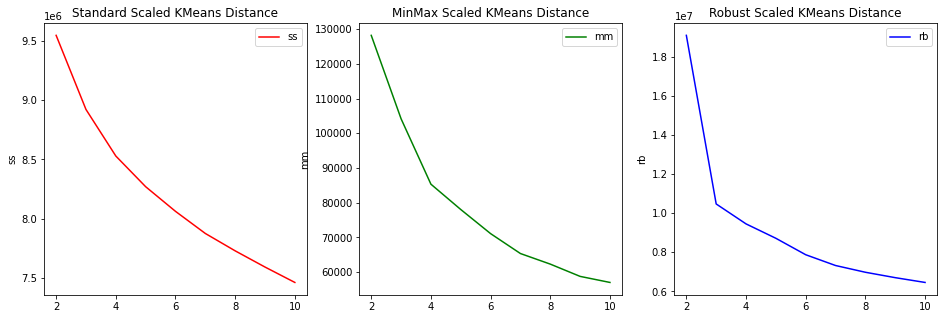

In [ ]:
plt.figure(figsize=(16, 5))

plt.subplot(131)
sns.lineplot(data=k_df, x=k_df.index, y='ss', label='ss', color='r')
plt.title("Standard Scaled KMeans Distance")

plt.subplot(132)
sns.lineplot(data=k_df, x=k_df.index, y='mm', label='mm', color='g')
plt.title("MinMax Scaled KMeans Distance")

plt.subplot(133)
sns.lineplot(data=k_df, x=k_df.index, y='rb', label='rb', color='b')
plt.title("Robust Scaled KMeans Distance")

plt.show()

#### 세가지 케이스에 대한 성능평가 Visualization 2
- 실루엣 계수를 사용한 성능평가

In [ ]:
sil_scores = {"ss": [], "mm": [], "rb": []}
for idx, data in enumerate([ss_x, mm_x, rb_x]):
  for i in range(2, 11):
    print(i)
    model=KMeans(n_clusters=i, random_state=13)
    model.fit(data)

    score = silhouette_score(data, model.labels_)
    sil_scores[list(sil_scores.keys())[idx]].append(score)
  print(f'end {list(sil_scores.keys())[idx]}')

2
3
4
5
6
7
8
9
10
end ss
2
3
4
5
6
7
8
9
10
end mm
2
3
4
5
6
7
8
9
10
end rb


In [ ]:
sil_df = pd.DataFrame(sil_scores)
sil_df.index = range(2, 11)

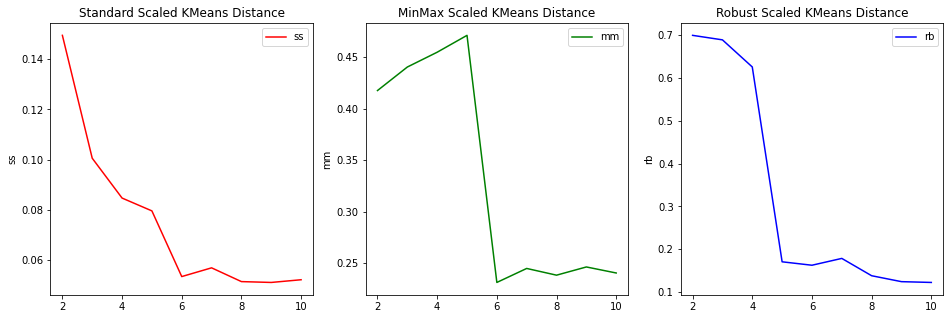

In [ ]:
plt.figure(figsize=(16, 5))

plt.subplot(131)
sns.lineplot(data=sil_df, x=sil_df.index, y='ss', label='ss', color='r')
plt.title("Standard Scaled KMeans Distance")

plt.subplot(132)
sns.lineplot(data=sil_df, x=sil_df.index, y='mm', label='mm', color='g')
plt.title("MinMax Scaled KMeans Distance")

plt.subplot(133)
sns.lineplot(data=sil_df, x=sil_df.index, y='rb', label='rb', color='b')
plt.title("Robust Scaled KMeans Distance")

plt.show()

#### 시각화를 통한 Clustering 성능평가
- PCA를 사용해 2차원으로 차원축소
- KMeans.n_clusters = 8일 때의 clustering 결과에 대한 시각화

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


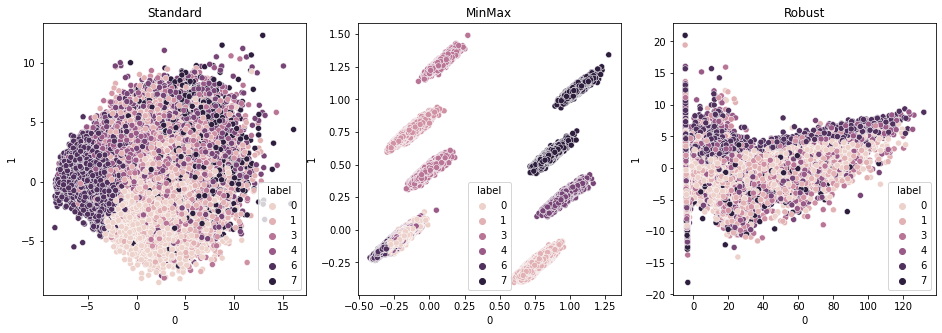

In [ ]:
plt.figure(figsize=(16, 5))

titles = ["Standard", "MinMax", "Robust"]
scaled_datas = [ss_x, mm_x, rb_x]
for idx, data in enumerate(scaled_datas):
  pca = PCA(n_components=2)
  result = pd.DataFrame(pca.fit_transform(data))
  result['label'] = model.labels_

  plt.subplot(1, 3, idx+1)
  sns.scatterplot(data=result, x=0, y=1, hue='label')
  plt.title(titles[idx])

plt.show()